# Reflection

In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps 
(along with potential observations from tools/the environment) to assess the quality of the chosen actions. 

This is then used downstream for things like re-planning, search, or evaluation.


https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection/

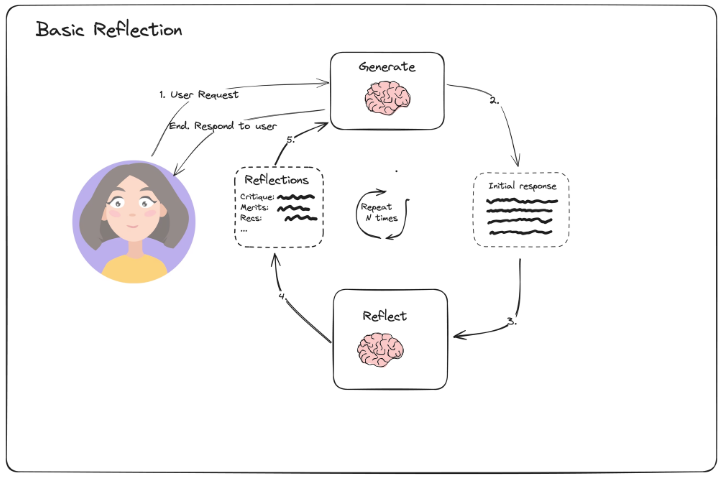

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI

os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Basic-Reflection"
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


# Generate
For our example, we will create a "5 paragraph essay" generator. 

First, create the generator:

In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 1-paragraph essays."
            " Generate the best essay possible for the user's request."
            " Keep the essay within 200 words "
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(model="gpt-4o-mini")

generate = prompt | llm

In [3]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

"The Little Prince," written by Antoine de Saint-Exupéry, remains profoundly relevant in modern childhood, serving as a timeless exploration of themes such as innocence, imagination, and the importance of human connections. In an age dominated by technology and fast-paced living, children often find themselves disconnected from their emotions and the natural world. The story’s protagonist, a young prince who travels from his home asteroid to various planets, symbolizes the purity of childhood curiosity and the quest for understanding. As he encounters different characters, each embodying adult shortcomings, readers are reminded of the essential values of love, friendship, and the wisdom that comes from seeing with the heart rather than the eyes. In today's context, where children frequently face pressures from social media and societal expectations, "The Little Prince" encourages them to cherish their uniqueness, embrace their imagination, and nurture genuine relationships. The book's 

# Reflect

In [4]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [5]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your essay on the relevance of "The Little Prince" in modern childhood presents a compelling argument by connecting the themes of the book with contemporary issues faced by children. You have successfully highlighted key elements such as innocence, imagination, and the importance of human connections, all of which are crucial in today's fast-paced and technology-driven world. However, there are several areas where you could improve the depth, structure, and style of your essay.

### Critique and Recommendations:

1. **Introduction and Thesis Statement:**
   - Your introduction is engaging, but it could benefit from a more explicit thesis statement that outlines the specific reasons why "The Little Prince" is relevant today. Consider revising your introduction to provide a clearer roadmap for your readers about what to expect in your essay.

2. **Depth and Examples:**
   - While you touch upon important themes, your arguments would be stronger with more specific examples from the text. 

# Repeat

And... that's all there is too it! 

You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [6]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Thank you for your detailed critique and recommendations. Here’s a revised version of the essay, incorporating your suggestions for improved depth, structure, and clarity.

---

In an age where childhood is increasingly influenced by technology and societal pressures, “The Little Prince” by Antoine de Saint-Exupéry offers essential insights that resonate deeply with modern youth. The tale of a young prince who traverses various planets embodies the core values of innocence, imagination, and authentic connections. Through his encounters with characters like the Businessman, who is consumed by numbers, and the Fox, who teaches him about relationships, the narrative critiques adult concerns that often overshadow the purity of childhood. For instance, the Little Prince learns that “what is essential is invisible to the eye,” reminding children to value emotional depth over superficial appearances—an important lesson in an era dominated by social media. Today’s children face the challenge o

# Define graph
Now that we've shown each step in isolation, we can wire it up in a graph.

In [7]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START


async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

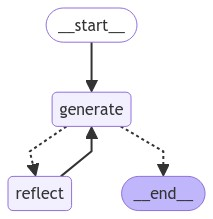

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    print(event)
    print("---")

{'generate': AIMessage(content='"The Little Prince," written by Antoine de Saint-Exupéry, continues to resonate in modern life, embodying timeless themes of innocence, love, and the critique of adult society. This enchanting tale, through the eyes of a young prince who travels from planet to planet, invites readers to reflect on the complexities of human relationships and the often-overlooked wisdom of childhood. In an age characterized by rapid technological advancement and social media saturation, the book\'s message about the importance of genuine connections and the value of seeing the world through a child\'s perspective is particularly poignant. The prince\'s encounters with various inhabitants serve as a critique of adult preoccupations—such as power, wealth, and superficiality—highlighting the necessity of nurturing our inner child and prioritizing what truly matters: love, friendship, and understanding. As individuals navigate the pressures of modern life, "The Little Prince" 

In [10]:
print(event)

{'generate': AIMessage(content='Thank you for your thoughtful critique and continued guidance! I appreciate your suggestions and will further refine the essay by incorporating more character development, expanding on the modern context, and enhancing the language and conclusion. Here’s the revised version:\n\n"The Little Prince," written by Antoine de Saint-Exupéry, remains profoundly relevant in modern life, embodying timeless themes of innocence, love, and a critique of adult society. The story follows a young prince who travels between planets, allowing readers to witness his encounters with various inhabitants. Each character—such as the king, who represents the folly of power, and the businessman, obsessed with wealth—serves as a critique of adult preoccupations that often overshadow the essence of human connection. The king\'s insistence on authority illustrates how adults can become blinded by the need for control, while the businessman highlights the emptiness of materialism. S

In [11]:
ChatPromptTemplate.from_messages(event[END]).pretty_print()

KeyError: '__end__'

In [12]:
graph

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<__root__>(recurse=True, writes=[ChannelWriteEntry(channel='__root__', value=<object object at 0x0000028C05919FE0>, skip_none=True, mapper=None)], require_at_least_one_of=['__root__']), ChannelWrite<start:generate>(recurse=True, writes=[ChannelWriteEntry(channel='start:generate', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'generate': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels=['__root__'], triggers=['start:generate', 'reflect', 'branch:generate:should_continue:generate'], writers=[ChannelWrite<generate,__root__>(recurse=True, writes=[ChannelWriteEntry(channel='generate', value='generate', skip_none=False, mapper=None), ChannelWriteEntry(channel='__root__', value=<object object at 0x0000028C05919FE0>, skip_none=True, mappe

In [ ]:
graph.